In [1]:
from Bio import PDB as pdb
%matplotlib inline
from matplotlib import pyplot as plt
# We'll be using itertools, which contains tools for creating iterators:
import itertools as it

# We'll again retrieve and load the closed clamp structure, 1czd, but also a structure of the open clamp on
# clamp loader, 3u60:
pdbl = pdb.PDBList()
filename_1czd = pdbl.retrieve_pdb_file('1czd')
filename_3u60 = pdbl.retrieve_pdb_file('3u60')
mmcifp = pdb.MMCIFParser()
structure_closed = mmcifp.get_structure('1czd', filename_1czd)
structure_open = mmcifp.get_structure('3u60', filename_3u60)

Structure exists: '/home/kent/kuriyanlab_python-workshops/2/cz/1czd.cif' 
Structure exists: '/home/kent/kuriyanlab_python-workshops/2/u6/3u60.cif' 


/opt/anaconda/envs/demo/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 17571.
  PDBConstructionWarning,
/opt/anaconda/envs/demo/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 17603.
  PDBConstructionWarning,
/opt/anaconda/envs/demo/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 17635.
  PDBConstructionWarning,
/opt/anaconda/envs/demo/lib/python3.6/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain E is discontinuous at line 17667.
  PDBConstructionWarning,


Small-angle X-ray scattering (SAXS) intensity measures the Fourier transform of the pair distribution function between electrons in a protein or macromolecule of interest. We will play around with predicting this pair distribution function from static structures (an approximation) for two different clamp states: open as in clamp-loader-bound structures, and closed. We will make three approximations: disregarding hydrogens, which are not in these structures and contribute little to the scattering, localizing electrons at atomic coordinates, and counting electrons based on element only.

In [2]:
# First, let's make sure we can select just the clamp chains in the open structure, which also contains the clamp
# loader, DNA, and ligands. We happen to know that the chains F, G, and H correspond to the clamp chains in this
# structure, but let's verify this by checking how well the sequence of chain A from the closed structure aligns
# to each chain in the open structure

from Bio import Align as align
aligner = align.PairwiseAligner()
aligner.mode = "local"
builder = pdb.PPBuilder()
# Note: in the Rosetta notebook in this workshop, there is an example of reading the sequence from the PDB header
# instead of from the coordinates

# Build the polypeptide sequence from the coordinates of chain A in the closed structure:
referencepp = builder.build_peptides(structure_closed[0]['A'])

for chain in structure_open.get_chains():
    # Note: we have to set aa_only to false to prevent the builder from stopping at selenomethionines
    chainpp = builder.build_peptides(chain, aa_only = False) # we could also call build_peptides with the structure
    if len(chainpp) > 0: # if a polypeptide was actually built (aka not a DNA/ligand chain letter)
        # Align and score this chain against chain A of the closed structure:
        chainscore = aligner.score(chainpp[0].get_sequence(), referencepp[0].get_sequence())
        # We could also print the alignment itself:
        # print(aligner.align(chainpp[0].get_sequence(), referencepp[0].get_sequence())[0])
        print("Chain " + chain.get_id() + " raw score: " + str(chainscore))
        print("  Score per length: " + str(chainscore / len(list(chain.get_residues()))))
        
# Here we were using the default parameters, which are not very useful for real alignments:
print(aligner)

Chain B raw score: 104.0
  Score per length: 0.32398753894080995
Chain C raw score: 104.0
  Score per length: 0.32298136645962733
Chain D raw score: 104.0
  Score per length: 0.32398753894080995
Chain E raw score: 84.0
  Score per length: 0.2736156351791531
Chain A raw score: 78.0
  Score per length: 0.41935483870967744
Chain G raw score: 228.0
  Score per length: 1.0
Chain H raw score: 228.0
  Score per length: 1.0
Chain F raw score: 228.0
  Score per length: 1.0
Pairwise sequence aligner with parameters
  match_score: 1.000000
  mismatch_score: 0.000000
  target_internal_open_gap_score: 0.000000
  target_internal_extend_gap_score: 0.000000
  target_left_open_gap_score: 0.000000
  target_left_extend_gap_score: 0.000000
  target_right_open_gap_score: 0.000000
  target_right_extend_gap_score: 0.000000
  query_internal_open_gap_score: 0.000000
  query_internal_extend_gap_score: 0.000000
  query_left_open_gap_score: 0.000000
  query_left_extend_gap_score: 0.000000
  query_right_open_gap_s

In [3]:
# Let's set reasonable match and mismatch penalties (we could also use a substitution matrix) and see what happens:
aligner.match_score = 1.0
aligner.mismatch_score = -2.0
aligner.gap_score = -2.5

for chain in structure_open.get_chains():
    chainpp = builder.build_peptides(chain, aa_only = False) # we could also call build_peptides with the structure
    if len(chainpp) > 0: # if a polypeptide was actually built (aka not a DNA/ligand chain letter)
        chainscore = aligner.score(chainpp[0].get_sequence(), referencepp[0].get_sequence())
        print("Chain " + chain.get_id() + " raw score: " + str(chainscore))
        print("  Score per length: " + str(chainscore / len(list(chain.get_residues()))))

Chain B raw score: 6.0
  Score per length: 0.018691588785046728
Chain C raw score: 6.0
  Score per length: 0.018633540372670808
Chain D raw score: 6.0
  Score per length: 0.018691588785046728
Chain E raw score: 3.0
  Score per length: 0.009771986970684038
Chain A raw score: 4.0
  Score per length: 0.021505376344086023
Chain G raw score: 228.0
  Score per length: 1.0
Chain H raw score: 228.0
  Score per length: 1.0
Chain F raw score: 228.0
  Score per length: 1.0


In [4]:
maxdist_closed = 0
numpairs_closed = 0

# We will use itertools.combinations to create an iterator over all unique pairs (r = 2) of atoms,
# without storing all of the pairs in memory at once:
for pair in it.combinations(structure_closed.get_atoms(), 2):
    if pair[0] - pair[1] > maxdist_closed:
        maxdist_closed = pair[0] - pair[1]
    numpairs_closed += 1
    
print(maxdist_closed)
print(numpairs_closed)
# There are over 13 million pairs of atoms in this structure

97.1033
13778625


In [5]:
# Let's do the same for the open conformation
maxdist_open = 0
numpairs_open = 0

# We will again use itertools, now to chain together the separate get_atoms() iterators into a single iterator,
# one after another:
open_atomiterator = it.chain(structure_open[0]['F'].get_atoms(),
                             structure_open[0]['G'].get_atoms(),
                             structure_open[0]['H'].get_atoms())

for pair in it.combinations(open_atomiterator, 2):
    if pair[0] - pair[1] > maxdist_open:
        maxdist_open = pair[0] - pair[1]
    numpairs_open += 1
    
print(maxdist_open)
print(numpairs_open)
# We got the same number of atom pairs and a larger maximum distance, which is reassuring

103.357834
13778625


In [6]:
import numpy as np

# This is our first time using a dictionary, a data structure that allow us to rapidly retrieve values based on
#               key: value    pairs
atomicnumber = {'H': 1,
                'C': 6,
                'N': 7,
                'O': 8,
                'S': 16,
                'SE': 16} # treat Se as S for this purpose

# Here we've created a dictionary that will tell us the atomic number of an element if we feed it the symbol as key

print(atomicnumber['N'])

# We'll manually histogram the atomic-number-weighted distances
end = max([maxdist_closed, maxdist_open]) + 1e-6 # add a tiny bit to the end to ensure the max is less than it
nbins = 3000
binedges = np.linspace(0, end, nbins + 1)
pairdist_closed = np.zeros(nbins, dtype = int) # empty arrays to hold the weighted histogram counts
pairdist_open = np.zeros(nbins, dtype = int)

for pair in it.combinations(structure_closed.get_atoms(), 2):
    dist = pair[0] - pair[1]
    distbin = int(nbins * dist / end)
    # Weight by product of atomic numbers for the pair:
    pairdist_closed[distbin] += atomicnumber[pair[0].element] * atomicnumber[pair[1].element]

# We have to recreate the iterator from before, which has been exhausted
open_atomiterator = it.chain(structure_open[0]['F'].get_atoms(),
                             structure_open[0]['G'].get_atoms(),
                             structure_open[0]['H'].get_atoms())
    
for pair in it.combinations(open_atomiterator, 2):
    dist = pair[0] - pair[1]
    distbin = int(nbins * dist / end)
    pairdist_open[distbin] += atomicnumber[pair[0].element] * atomicnumber[pair[1].element]

7


Text(0.5, 1.0, 'Electronic pair distribution function for T4 clamp')

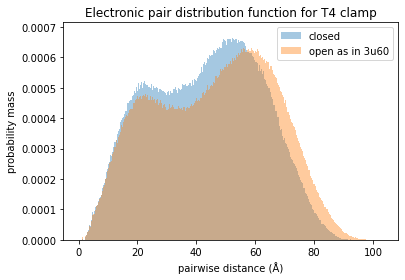

In [7]:
binwidth = binedges[1] - binedges[0]

plt.bar(binedges[:-1], pairdist_closed / np.sum(pairdist_closed), binwidth, align = 'edge', alpha = 0.4)
plt.bar(binedges[:-1], pairdist_open / np.sum(pairdist_open), binwidth, align = 'edge', alpha = 0.4)
plt.legend(["closed", "open as in 3u60"])
plt.xlabel("pairwise distance (Å)")
plt.ylabel("probability mass")
plt.title("Electronic pair distribution function for T4 clamp")

5min 23s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


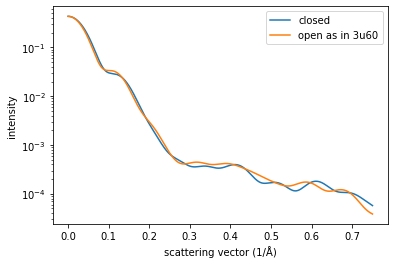

In [8]:
%%timeit -n 1 -r 1
# For fun, let's use the magic IPython function timeit to see how long this block takes to run

# Now let's try to get an approximate intensity curve for each structure
# Note: if this cell is running slowly, interrupt it (Kernal -> Interrupt) and run the alternative below

q_values = np.linspace(1e-6, 0.75, 10000) # avoid dividing by 0...
intensities_closed = np.zeros(len(q_values))
intensities_open = np.zeros(len(q_values))

closed_sum = np.sum(pairdist_closed)
open_sum = np.sum(pairdist_open)

# Using the Debye scattering equation to transform p(r) to I(q):
for i in range(len(q_values)):
    for j in range(len(pairdist_closed)):
        rj = binwidth * j + binwidth / 2
        intensities_closed[i] += 4 * np.pi * binwidth * np.sin(q_values[i] * rj) * pairdist_closed[j] / \
                              (closed_sum * q_values[i] * rj)
        intensities_open[i] += 4 * np.pi * binwidth * np.sin(q_values[i] * rj) * pairdist_open[j] / \
                              (open_sum * q_values[i] * rj)
        
plt.plot(q_values, intensities_closed)
plt.plot(q_values, intensities_open)
plt.yscale("log")
plt.xlabel("scattering vector (1/Å)")
plt.ylabel("intensity")
plt.legend(["closed", "open as in 3u60"])
# We have a reasonable-looking plot, but this method was quite slow...

1.24 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


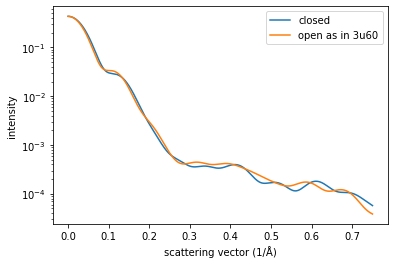

In [9]:
%%timeit -n 1 -r 1

# We recognize that the double for loop could be recreated using NumPy functions operating over the outer product
# (https://en.wikipedia.org/wiki/Outer_product) of the real- and reciprocal-space values we're iterating over

closed_sum = np.sum(pairdist_closed)
open_sum = np.sum(pairdist_open)

q_values = np.linspace(1e-6, 0.75, 10000) # avoid dividing by 0...
r_values = binedges[:-1] + binwidth / 2
# This expression is identical to the double for loop above:
intensities_closed = 4 * np.pi * binwidth * np.sum(pairdist_closed * np.sin(np.outer(q_values, r_values)) / \
                                                   np.outer(q_values, r_values), axis = 1) / closed_sum
intensities_open = 4 * np.pi * binwidth * np.sum(pairdist_open * np.sin(np.outer(q_values, r_values)) / \
                                                 np.outer(q_values, r_values), axis = 1) / open_sum

plt.plot(q_values, intensities_closed)
plt.plot(q_values, intensities_open)
plt.yscale("log")
plt.xlabel("scattering vector (1/Å)")
plt.ylabel("intensity")
plt.legend(["closed", "open as in 3u60"])

# Taking advantage of these optimized NumPy functions and the inherent parallism in our problem saved a lot of time